In [14]:
import torch
torch.cuda.empty_cache()
torch.manual_seed(0)

from torch.nn.functional import interpolate

import hr_dv2.transform as tr
from hr_dv2.utils import *
from hr_dv2 import HighResDV2
from hr_dv2.high_res import torch_pca

import numpy as np
np.random.seed(0)
from PIL import Image
import matplotlib.pyplot as plt

from featup.util import norm, unnorm
use_norm = True

In [15]:
IMG_SIZE = 322
def load_img(path: str, size: int=IMG_SIZE) -> tuple[torch.Tensor, np.ndarray]:
    _img = Image.open(path)
    _h, _w = _img.height, _img.width
    t = tr.get_input_transform(size, size)

    img_tensor, img = tr.load_image(path, t)
    img_arr = np.array(img)

    img_tensor.to(torch.float16)
    return img_tensor, img_arr

def set_transforms(net: torch.nn.Module, stride: int=4):
    shift_dists = [i for i in range(1, stride - 1)]
    fwd_shift, inv_shift = tr.get_shift_transforms(shift_dists, 'Moore')
    fwd_flip, inv_flip = tr.get_flip_transforms()
    fwd, inv = tr.combine_transforms(fwd_shift, fwd_flip, inv_shift, inv_flip)
    net.set_transforms(fwd, inv)

In [16]:
dv2 = HighResDV2("dinov2_vits14_reg", 4, dtype=torch.float16)
set_transforms(dv2)
dv2.eval()
dv2.cuda()

d8 = HighResDV2("dino_vits8", 4, dtype=torch.float16)
set_transforms(d8)
d8.eval()
d8.cuda()

jbu = torch.hub.load("mhamilton723/FeatUp", 'dinov2', use_norm=use_norm)
jbu.eval()
jbu.cuda()
pass

Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dinov2_main
Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dino_main
Using cache found in /home/ronan/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dinov2_main


In [17]:
out = []
for path in ["4.jpg", "plant.png"]:
    img_tensor, img_arr = load_img(f'fig_data/{path}')
    img_tensor = img_tensor.cuda()
    out.append(img_arr)


    for i, model in enumerate([d8, dv2, jbu]):
        if i == 2:
            tensor = img_tensor.unsqueeze(0)
        else:
            tensor = img_tensor

        feats_attn_tensor = model(tensor)

        if i == 2:
            feats_attn_tensor = interpolate(feats_attn_tensor, (IMG_SIZE, IMG_SIZE))

        pcaed = torch_pca(feats_attn_tensor.squeeze(0), 3, max_samples=80000)
        pcaed = tr.to_numpy(pcaed)
        rescaled = rescale_pca(pcaed)
        out.append(rescaled)

In [18]:
def add_inset_zoom(xywh: list[int], fig_xywh: list[float], img_arr: np.ndarray, ax ) -> object:
    x0, y0, w, h = xywh
    fx, fy, fw, fh = fig_xywh
    H, W, C = img_arr.shape
    inset_data = np.zeros_like(img_arr)
    inset_data[y0:y0+h, x0:x0+w, :] = img_arr[y0:y0+h, x0:x0+w, :]
    extent = (0, H, W, 0)
    # 418 / 518, 0 / 518, 150 / 518, 150 / 518
    axin = ax.inset_axes(
        fig_xywh, xlim=(x0, x0+w), ylim=(y0, y0+h))
    axin.set_axis_off()
    axin.imshow(inset_data)
    ax.indicate_inset_zoom(axin, edgecolor="r", lw=2)
    axin.set_ylim((y0 + h, y0))
    return axin

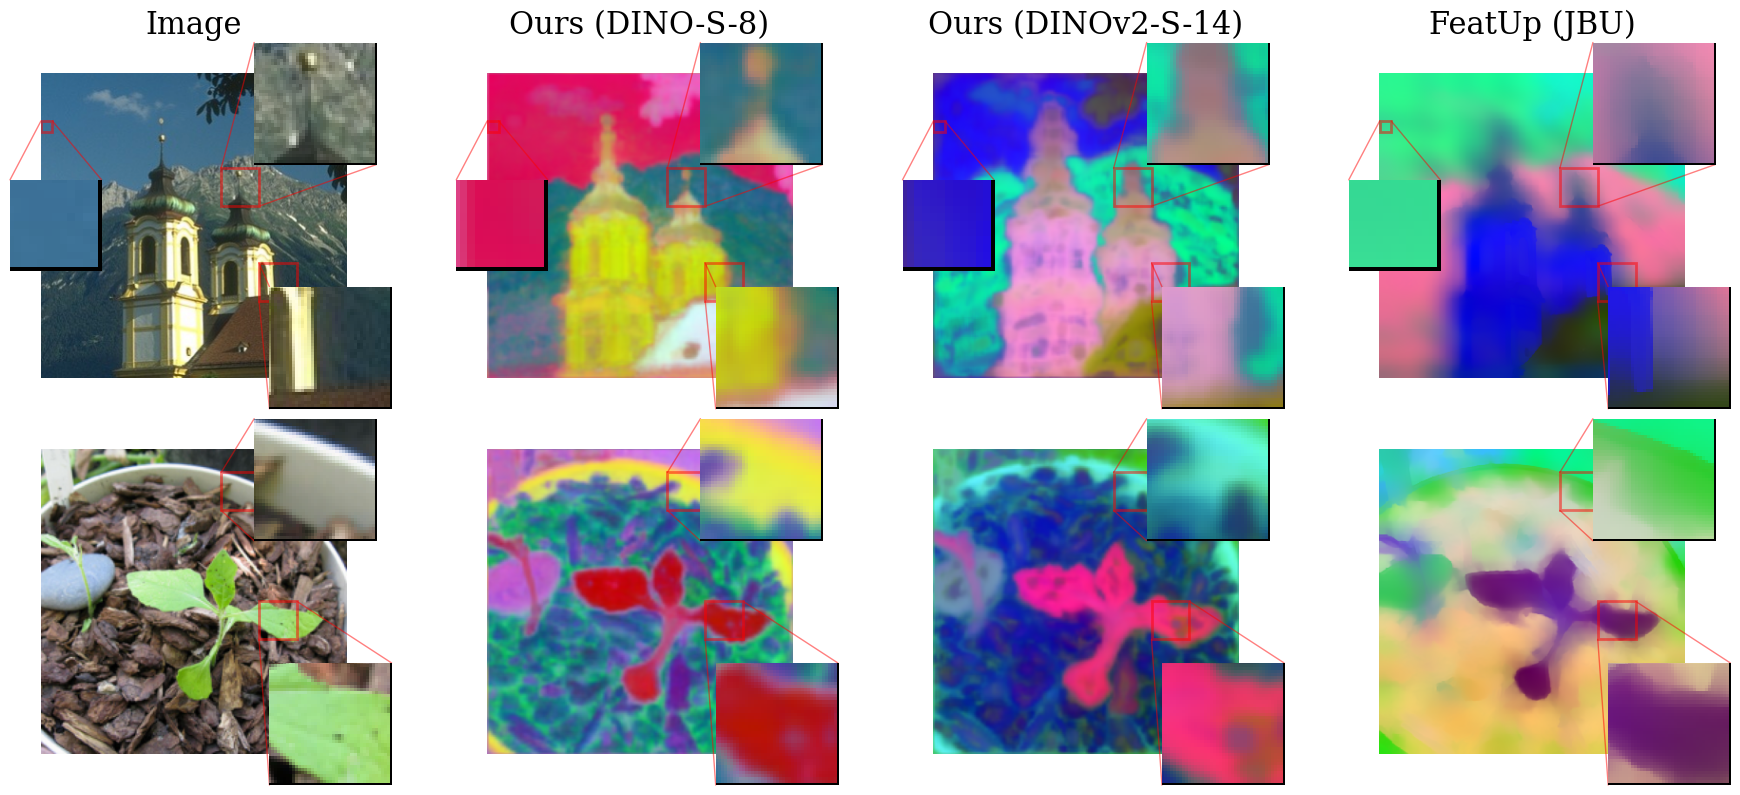

In [19]:
fig, axs = plt.subplots(2, 4)

fig.set_size_inches(18, 8)
plt.rcParams["font.family"] = "serif"
titles = ["Image", "Ours (DINO-S-8)", "Ours (DINOv2-S-14)", "FeatUp (JBU)"]

greyscale_pil = Image.fromarray(img_arr).convert('L').convert('RGB')
c = 0
for j in range(2):
    for i in range(4):
        ax = axs[j, i]
        data = out[c].reshape(IMG_SIZE, IMG_SIZE, 3)

        ax.set_axis_off()
        ax.imshow(data)
        if j == 0:
            ax.set_title(titles[i], fontsize=22)
            add_inset_zoom([190, 100, 40, 40], [0.7, 0.7, 0.4, 0.4], data, ax)
            add_inset_zoom([230, 200, 40, 40], [0.75, -0.1, 0.4, 0.4], data, ax)
            add_inset_zoom([0, 50, 12, 12], [-0.1, 0.35, 0.3, 0.3], data, ax)
        else:
            add_inset_zoom([190, 24, 40, 40], [0.7, 0.7, 0.4, 0.4], data, ax)
            add_inset_zoom([230, 160, 40, 40], [0.75, -0.1, 0.4, 0.4], data, ax)
        c += 1
plt.tight_layout()
plt.savefig('fig_out/supp_limits')